# Data Collection
## Introduction

In [111]:
# Import libraries
import numpy as np
import pandas as pd
import requests
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from datetime import datetime, timedelta


print("Library verions:")
print("- numpy:", np.__version__)
print("- pandas:", pd.__version__)
print("- requests:", requests.__version__)
print("- sklearn:", sklearn.__version__)
print("- seaborn:", sns.__version__)

Library verions:
- numpy: 2.2.0
- pandas: 2.3.2
- requests: 2.32.5
- sklearn: 1.7.2
- seaborn: 0.13.2


In [20]:
# Set API key (for traffic data and weather data)
TOMTOM_API_KEY = "ZLhH20PVZkOu63eSrlNGz81QAzPA9WEi"
OPENWEATHER_API_KEY = "1c37968bc1e6a8842d2785a8e6b0e52e"

# Coordinates for key locations (latitude, longitude) in HCMC
hcmc_locations = {
    "District_1": {"lat": 10.7757, "lon": 106.7009},
    "Thu_Thiem": {"lat": 10.7835, "lon": 106.7215},
    "Tan_Son_Nhat": {"lat": 10.8181, "lon": 106.6519},
    "Binh_Thanh": {"lat": 10.8106, "lon": 106.7091},
    "Phu_My_Hung": {"lat": 10.7272, "lon": 106.7057}
}

In [21]:
# 1. Data Requirements
print("Data Requirements for HCMC Traffic Prediction")
data_requirements = {
    'Traffic_Flow': 'Real-time traffic flow data from key locations',
    'Traffic_Speed': 'Average vehicle speed on major roads',
    'Traffic_Congestion': 'Congestion level (0-100%)',
    'Weather_Conditions': 'Current weather conditions (temperature, precipitation, etc.)',
    'Time_Data': 'Timestamp, day of week, hour of day',
    'Location_Data': 'GPS coordinates of traffic monitoring points'
}
for key, value in data_requirements.items():   
    print(f"- {key}: {value}")

Data Requirements for HCMC Traffic Prediction
- Traffic_Flow: Real-time traffic flow data from key locations
- Traffic_Speed: Average vehicle speed on major roads
- Traffic_Congestion: Congestion level (0-100%)
- Weather_Conditions: Current weather conditions (temperature, precipitation, etc.)
- Time_Data: Timestamp, day of week, hour of day
- Location_Data: GPS coordinates of traffic monitoring points


In [ ]:
# 2. Collect the data 
# Function to get traffic data from TomTom API
def get_traffic_data(lat, lon, api_key, save_to_file=True):
    url = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
    params ={
            'point': f"{lat},{lon}",
            'unit': 'KMPH',
            'key': api_key,
            'zoom': 12
    }
    try:
        reponse = requests.get(url, params=params)
        data = reponse.json()
        if save_to_file:
            os.makedirs('traffic_data', exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"traffic_data/traffic_{lat}_{lon}_{timestamp}.json"
            with open(filename, 'w') as f:
                json.dump(data, f)
        return data
    except Exception as e:
        print(f"Error fetching traffic data: {e}")
        return None

print("Collecting traffic data...")
traffic_data = {}
for name, coords in hcmc_locations.items():
    print(f"Fetching traffic data for {name}...")
    data = get_traffic_data(coords["lat"], coords["lon"], TOMTOM_API_KEY)
    if data:
        traffic_data[name] = data
    time.sleep(1)

print("Traffic data collection completed!")

# Function to get weather data from OpenWeatherMap API
def get_weather_data(lat, lon, api_key, save_to_file=True):
    url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': 'metric'
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        if save_to_file:
            os.makedirs('weather_data', exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"weather_data/weather_{lat}_{lon}_{timestamp}.json"
            with open(filename, 'w') as f:
                json.dump(data, f)
        return data
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return None


print("Collecting weather data...")
weather_data = {}
for name, coords in hcmc_locations.items():
    print(f"Fetching weather data for {name}...")
    data = get_weather_data(coords["lat"], coords["lon"], OPENWEATHER_API_KEY)
    if data:
        weather_data[name] = data
    time.sleep(1)
print("Weather data collection completed!")




Fetching traffic data for District_1...
Fetching traffic data for Thu_Thiem...
Fetching traffic data for Tan_Son_Nhat...
Fetching traffic data for Binh_Thanh...
Fetching traffic data for Phu_My_Hung...
Traffic data collection completed!
Fetching weather data for District_1...
Fetching weather data for Thu_Thiem...
Fetching weather data for Tan_Son_Nhat...
Fetching weather data for Binh_Thanh...
Fetching weather data for Phu_My_Hung...
Weather data collection completed!


In [118]:
# 3. Process and merge datasets
# Process traffic data
def process_traffic_data(traffic_data_dict):
    processed_data = []
    
    for location_name, data in traffic_data_dict.items():
        if data and 'flowSegmentData' in data:
            segment = data['flowSegmentData']
            processed_data.append({
                'Location': location_name,
                'Timestamp': datetime.now(),
                'Current_Speed': segment.get('currentSpeed', 0), # this is the current speed of traffic
                'Free_Flow_Speed': segment.get('freeFlowSpeed', 0), # this is the speed when there is no traffic
                'Confidence': segment.get('confidence', 0), # this indicates the reliability of the data (value rang e from 0 to 1)
                'Congestion_Level': segment.get('currentTravelTime', 0) / segment.get('freeFlowTravelTime', 1) * 100, # this indicates how congested the traffic is (percentage)
                'Road_Closure': segment.get('roadClosure', False) # this indicates if the road is closed to traffic or not 
            })
    
    return pd.DataFrame(processed_data)

# Process weather data
def process_weather_data(weather_data):
    if weather_data and 'main' in weather_data:
        return {
            'Timestamp': datetime.now(),
            'Hour': datetime.now().hour,
            'Day_of_Week': datetime.now().weekday(),
            'Temperature': weather_data['main'].get('temp', 0),
            'Humidity': weather_data['main'].get('humidity', 0),
            'Wind_Speed': weather_data['wind'].get('speed', 0) if 'wind' in weather_data else 0, # wind speed if not return 0
            'Rainfall': weather_data['rain']['1h'] if 'rain' in weather_data and '1h' in weather_data['rain'] else 0 # rainfall in last 1 hour if not return 0
        }
    return None

# Process the collected data
traffic_df = process_traffic_data(traffic_data)
weather_info = process_weather_data(weather_data)

# Merge datasets
if weather_info:
    weather_df = pd.DataFrame([weather_info])
    # Add weather data to each traffic record
    for col in weather_df.columns:
        if col != 'Timestamp':
            traffic_df[col] = weather_df[col].iloc[0]


# Add time-based features
traffic_df['Hour'] = traffic_df['Timestamp'].dt.hour
traffic_df['Day_of_Week'] = traffic_df['Timestamp'].dt.dayofweek
traffic_df['Is_Weekend'] = (traffic_df['Day_of_Week'] >= 5).astype(int)
# Rush hour indicator (7-9 AM and 4-7 PM)
traffic_df['Is_Rush_Hour'] = ((traffic_df['Hour'] >= 7) & (traffic_df['Hour'] <= 9) | 
                             (traffic_df['Hour'] >= 16) & (traffic_df['Hour'] <= 19)).astype(int)

print("Processed Data Sample:")
traffic_df.head()


Processed Data Sample:


,Location,Timestamp,Current_Speed,Free_Flow_Speed,Confidence,Congestion_Level,Road_Closure,Hour,Day_of_Week,Temperature,Humidity,Wind_Speed,Rainfall,Is_Weekend,Is_Rush_Hour
0,District_1,2025-09-17 09:38:10.861430,12,25,1,206.060606,False,9,2,29.99,74,3.6,0,0,1
1,Thu_Thiem,2025-09-17 09:38:10.863049,40,40,1,100.000000,False,9,2,29.99,74,3.6,0,0,1
2,Tan_Son_Nhat,2025-09-17 09:38:10.867083,31,31,1,100.000000,False,9,2,29.99,74,3.6,0,0,1
3,Binh_Thanh,2025-09-17 09:38:10.869082,26,33,1,127.411168,False,9,2,29.99,74,3.6,0,0,1
4,Phu_My_Hung,2025-09-17 09:38:10.871112,42,42,1,100.000000,False,9,2,29.99,74,3.6,0,0,1


In [37]:
# 4. Where to store your collected data
print("Saving processed data to CSV...")
traffic_df.to_csv('hcmc_traffic_data.csv', index=False)
print("Data saved to 'hcmc_traffic_data.csv'")

Saving processed data to CSV...
Data saved to 'hcmc_traffic_data.csv'


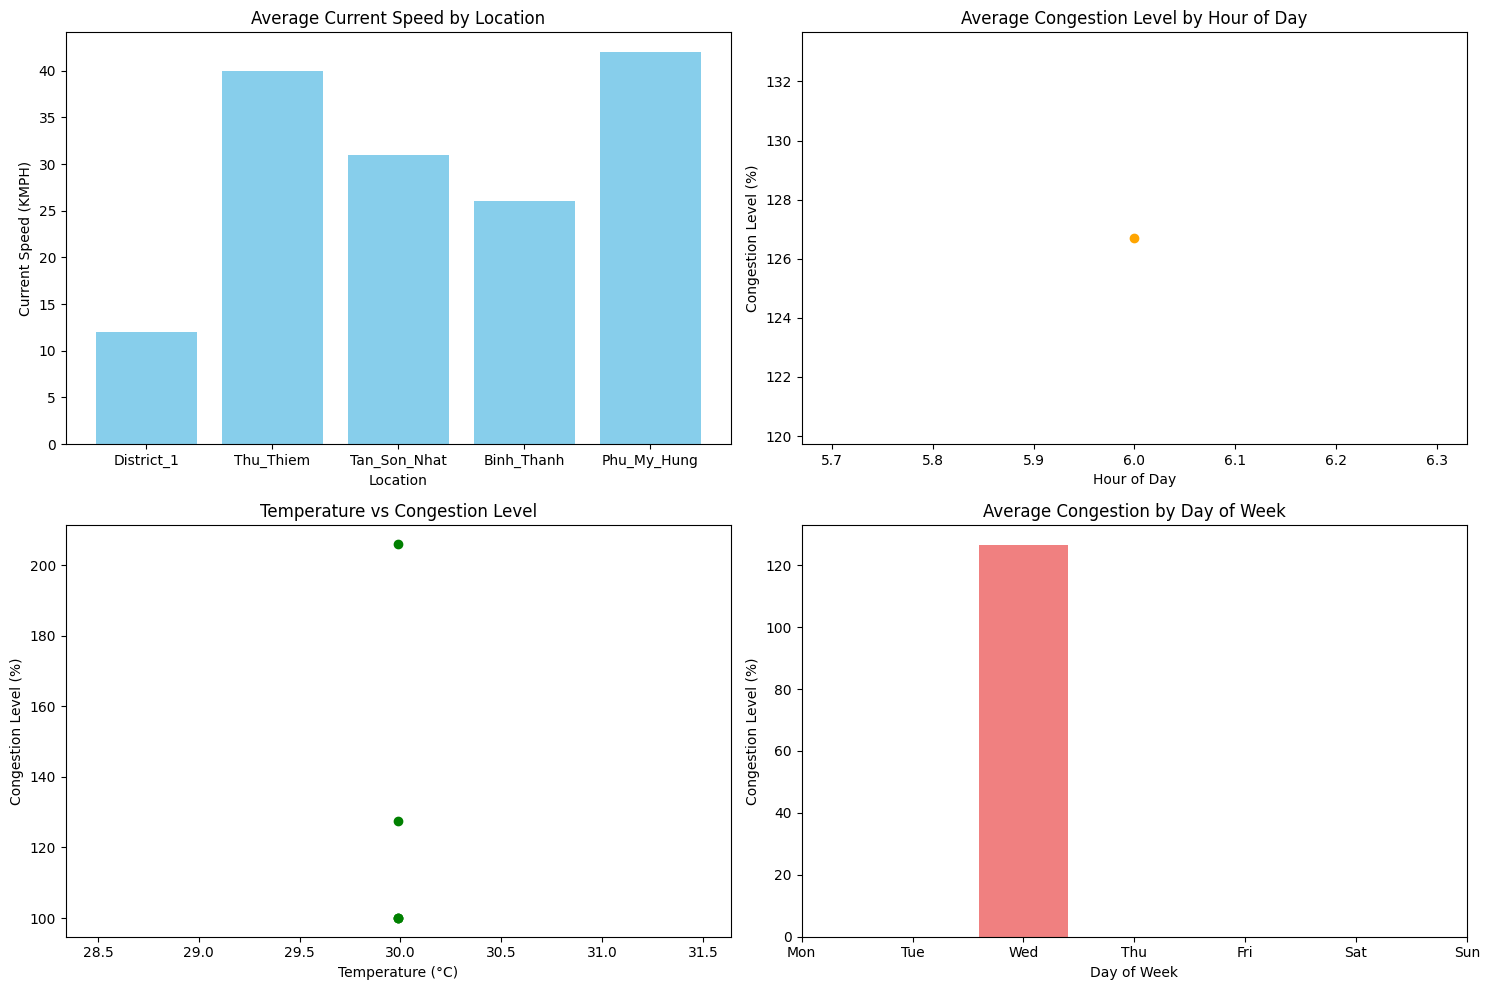

In [76]:
# 5. Visualize the traffic data
plt.figure(figsize=(15, 10))

# Plot 1: Avarage Current Speed by Location
plt.subplot(2, 2, 1)
plt.bar(traffic_df['Location'], traffic_df['Current_Speed'], color='skyblue')
plt.title('Average Current Speed by Location')
plt.xlabel('Location')
plt.ylabel('Current Speed (KMPH)')  

# Plot 2: Congestion level by hour of day 
plt.subplot(2, 2, 2)
hourly_congestion = traffic_df.groupby('Hour')['Congestion_Level'].mean()
plt.plot(hourly_congestion.index, hourly_congestion.values, marker='o', color='orange')
plt.title('Average Congestion Level by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Congestion Level (%)')


# Plot 3: Temperature vs Congestion Level
plt.subplot(2, 2, 3)
plt.scatter(traffic_df['Temperature'], traffic_df['Congestion_Level'], color='green')
plt.title('Temperature vs Congestion Level')
plt.xlabel('Temperature (°C)')
plt.ylabel('Congestion Level (%)')

# Plot 4: Humidity vs Congestion Level
plt.subplot(2, 2, 4)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_congestion = traffic_df.groupby('Day_of_Week')['Congestion_Level'].mean()
plt.bar(daily_congestion.index, daily_congestion.values, color='lightcoral')
plt.title('Average Congestion by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Congestion Level (%)')
plt.xticks(range(7), days)

plt.tight_layout()
plt.show()




In [114]:
# 7. Modeling with Linear Regression and KNN
print("Preparing data for traffic prediction modeling...")

# prepare features and target variable
features = ['Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Temperature', 'Humidity', 'Congestion_Level', 'Wind_Speed']
target = 'Current_Speed'

X = traffic_df[features]
y = traffic_df[target]

# Check for missing values
print("Missing values in features:")
print(X.isnull().sum())
print("Missing values in target:")
print(y.isnull().sum())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Preparing data for traffic prediction modeling...
Missing values in features:
Hour                0
Day_of_Week         0
Is_Weekend          0
Is_Rush_Hour        0
Temperature         0
Humidity            0
Congestion_Level    0
Wind_Speed          0
dtype: int64
Missing values in target:
0


Training Linear Regression model...


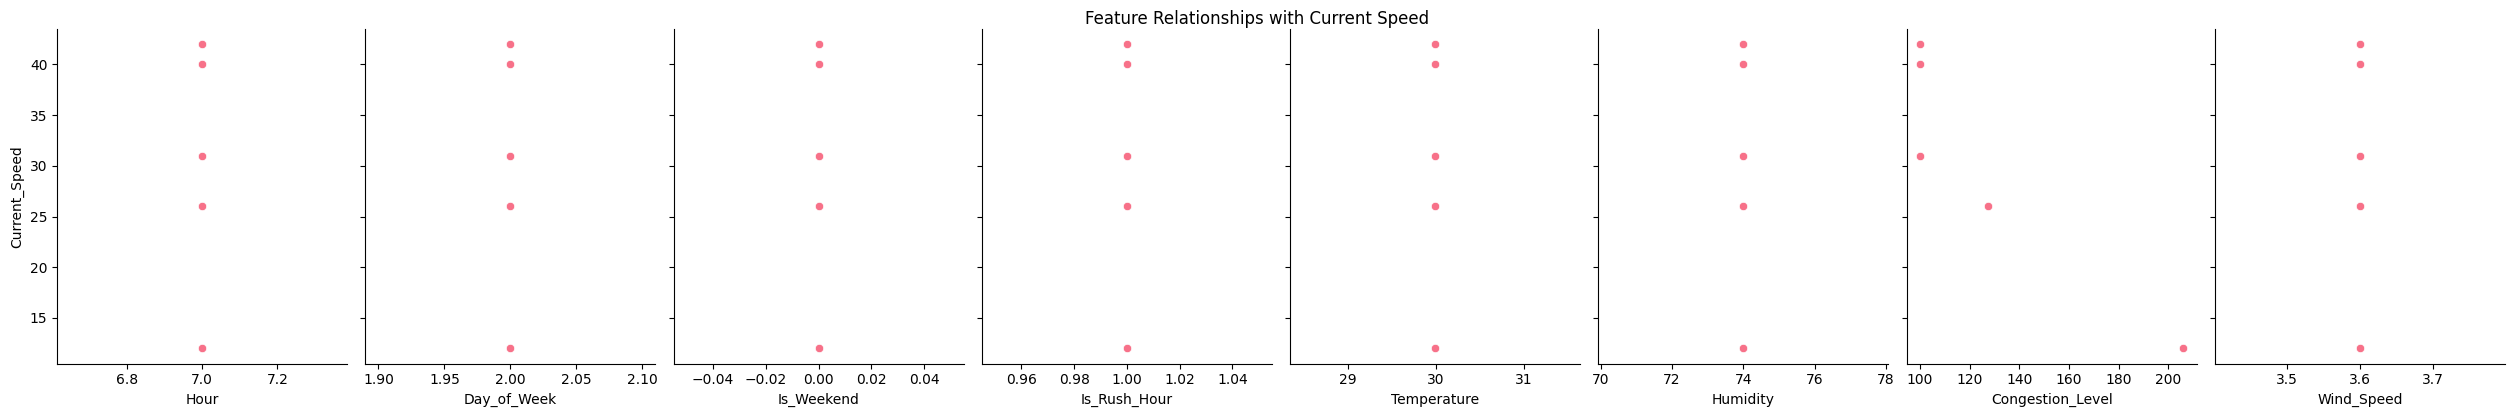

KNN Model Accuracy: 0.00
Classification Report for KNN:
              precision    recall  f1-score   support

        33.0       0.00      0.00      0.00       0.0
        40.0       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [116]:
# Scaling model for KNN
print("Training Linear Regression model...")
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

plot = sns.pairplot(traffic_df, x_vars=features, y_vars=target, height=4, aspect=0.8)
plt.suptitle('Feature Relationships with Current Speed', y=1.02)
plt.show()

# Modelling for KNN
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
score = accuracy_score(y_test, pred)
print(f"KNN Model Accuracy: {score:.2f}")

# Report for KNN 
report = classification_report(y_test, pred)
print("Classification Report for KNN:")
print(report)


In [ ]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Model Evaluation Metrics:")
print(f"Mean Squared Error: {mse:.2f}")

Model Evaluation Metrics:
Mean Squared Error: 21.64


In [98]:
# 8. Data Dictionary
print("Creating data dictionary...")

data_dict = {
    'Data Element Name': [
        'Location', 'Timestamp', 'Current_Speed', 'Free_Flow_Speed', 
        'Congestion_Level', 'Confidence', 'Road_Closure', 'Temperature',
        'Humidity', 'Pressure', 'Weather_Description', 'Wind_Speed',
        'Rainfall', 'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour'
    ],
    'Data Type': [
        'Categorical', 'DateTime', 'Numeric', 'Numeric', 'Numeric', 
        'Numeric', 'Boolean', 'Numeric', 'Numeric', 'Numeric', 
        'Categorical', 'Numeric', 'Numeric', 'Numeric', 'Numeric', 
        'Boolean', 'Boolean'
    ],
    'Units': [
        'Text', 'DateTime', 'km/h', 'km/h', 'Percentage', 
        'Percentage', 'Boolean', '°C', '%', 'hPa', 
        'Text', 'm/s', 'mm', 'Hour (0-23)', 'Day (0-6)', 
        'Boolean', 'Boolean'
    ],
    'Range/Description': [
        'District names in HCMC', 'Date and time of measurement', 
        'Current traffic speed (5-80 km/h)', 'Free flow speed under ideal conditions',
        'Congestion level (0-200%)', 'Data confidence level (0-100%)',
        'Whether road is closed', 'Temperature in Celsius',
        'Relative humidity', 'Atmospheric pressure', 
        'Description of weather conditions', 'Wind speed',
        'Rainfall in last hour', 'Hour of day (0-23)', 
        'Day of week (0=Monday, 6=Sunday)', 'Whether it is weekend',
        'Whether it is rush hour (7-9 AM, 4-7 PM)'
    ],
    'Source': [
        'Predefined locations', 'API timestamp', 'TomTom API', 'TomTom API',
        'Calculated (CurrentTravelTime/FreeFlowTravelTime)', 'TomTom API',
        'TomTom API', 'OpenWeatherMap API', 'OpenWeatherMap API', 
        'OpenWeatherMap API', 'OpenWeatherMap API', 'OpenWeatherMap API',
        'OpenWeatherMap API', 'Derived from Timestamp', 'Derived from Timestamp',
        'Derived from Day_of_Week', 'Derived from Hour'
    ]
}

data_dict_df = pd.DataFrame(data_dict)
print("Data Dictionary:")
print(data_dict_df.to_string(index=False))

# 9. Save final dataset and model
print("Saving final dataset and model information...")
final_df.to_csv('hcmc_traffic_final_dataset.csv', index=False)

Creating data dictionary...
Data Dictionary:
  Data Element Name   Data Type       Units                        Range/Description                                            Source
           Location Categorical        Text                   District names in HCMC                              Predefined locations
          Timestamp    DateTime    DateTime             Date and time of measurement                                     API timestamp
      Current_Speed     Numeric        km/h        Current traffic speed (5-80 km/h)                                        TomTom API
    Free_Flow_Speed     Numeric        km/h   Free flow speed under ideal conditions                                        TomTom API
   Congestion_Level     Numeric  Percentage                Congestion level (0-200%) Calculated (CurrentTravelTime/FreeFlowTravelTime)
         Confidence     Numeric  Percentage           Data confidence level (0-100%)                                        TomTom API
       Roa